## Introduction
This example will show the steps needed to build a 3D image classification
model using a 3D convolutional neural network (CNN) to predict the location
of cancerous regions in CT scans.
## Why 3D CNNs at all?
Traditional use-cases of CNNs are RGB images (3 channels). The goal of
a 3D CNN is to take as input a 3D volume or a sequence of frames
(e.g. slices in a CT scan) and extract features from it. A traditional CNN
extract representations of a single image and puts them in a vector state
(latent space), whereas a 3D CNN extracts representations of a set of images
which is required to make predictions from volumetric data (e.g. CT scans).
A 3D CNN takes the temporal dimension (e.g. 3D context) into account. This way
of learning representations from a volumetric data is useful to find the right
label. This is achieved by using 3D convolutions.

## References

- [A survey on Deep Learning Advances on Different 3D DataRepresentations](https://arxiv.org/pdf/1808.01462.pdf)

- [VoxNet: A 3D Convolutional Neural Network for Real-Time ObjectRecognition](https://www.ri.cmu.edu/pub_files/2015/9/voxnet_maturana_scherer_iros15.pdf)

- [FusionNet: 3D Object Classification Using MultipleData Representations](http://3ddl.cs.princeton.edu/2016/papers/Hegde_Zadeh.pdf)

- [Uniformizing Techniques to Process CT scans with 3D CNNs for Tuberculosis Prediction](https://arxiv.org/abs/2007.13224)



In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


## Downloading the  NSCLC-Radiomics-Genomics dataset
Since training 3D convolutional neural network are time consuming, a subset of the
NSCLC-Radiomics-Genomics dataset is used which consists of CT scans
with gene expression and relevant clinical data. In this example, we will be
using the "location" attribtute among the available clinical data to build a
classifier to predict cancerious regions (left or right). Hence, the task is
a binary classification problem.

In [2]:
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.1/NSCLC-Radiomics-Genomics.zip"
filename = os.path.join(os.getcwd(), "NSCLC-Radiomics-Genomics.zip")
keras.utils.get_file(filename, url)

with zipfile.ZipFile("NSCLC-Radiomics-Genomics.zip", "r") as z_fp:
    z_fp.extractall("./")

1927217152/1927209723 [==============================] - 53s 0us/step


## Load data
The files are provided in Nifti format with the extension .nii. To read the
scans, the nibabel package is used. To process the data, the following
is done:
* Volumes are originally rotated by 90 degress, so the orientation is fixed
* Resize width, height and depth

Here several helper functions are defined to process the data. These functions
will be used when building training and test datasets.

In [3]:
import numpy as np
import nibabel as nib
import cv2

from scipy.ndimage import zoom


def read_nifti_file(filepath):
    # read file
    scan = nib.load(filepath)
    # get raw data
    scan = scan.get_fdata()
    # rotate
    scan = np.rot90(np.array(scan))
    return scan


def resize_slices(img):
    # resize all slices
    flatten = [
        cv2.resize(img[:, :, i], (128, 128), interpolation=cv2.INTER_CUBIC)
        for i in range(img.shape[-1])
    ]
    # stack along the z-axis
    img = np.array(np.dstack(flatten))
    return img


def resize_depth(img):
    # set the desired depth
    desired_depth = 128
    # get current depth
    current_depth = img.shape[-1]
    # compute depth factor
    depth = current_depth / desired_depth
    depth_factor = 1 / depth
    # resize across z-axis
    img_new = zoom(img, (1, 1, depth_factor), mode="nearest")
    return img_new


def process_scan(path):
    # read scan
    volume = read_nifti_file(path)
    # resize width and height
    volume = resize_slices(volume)
    # resize across z-axis
    volume = resize_depth(volume)
    return volume

Let's read the paths of the CT scans from the class directories

In [4]:
# folder "1" consist of right CT scans
right_scan_paths = [
    os.path.join(os.getcwd(), "NSCLC-Radiomics-Genomics/1", x)
    for x in os.listdir("NSCLC-Radiomics-Genomics/1")
]
# folder "2" consist of left CT scans
left_scan_paths = [
    os.path.join(os.getcwd(), "NSCLC-Radiomics-Genomics/2", x)
    for x in os.listdir("NSCLC-Radiomics-Genomics/2")
]

print("CT scans with cancerous regions in left side: " + str(len(left_scan_paths)))
print("CT scans with cancerous regions in right side: " + str(len(right_scan_paths)))

CT scans with cancerous regions in left side: 20
CT scans with cancerous regions in right side: 20


Let's visualize a CT scan and it's shape.

Dimension of the CT scan is: (512, 512, 61)


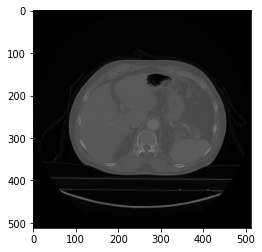

In [110]:
import matplotlib.pyplot as plt

img = read_nifti_file(right_scan_paths[10])
print("Dimension of the CT scan is:", img.shape)
plt.imshow(img[:, :, 5], cmap="gray")

Since a CT scan has many slices, let's visualize a montage of the slices.

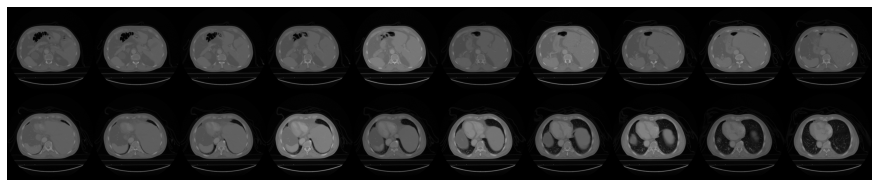

In [111]:
def plot_slices(data):
    # plot a montage of 20 CT slices
    num_rows, num_columns = 2, 10
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, 512, 512))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data, columns_data, figsize=(fig_width, fig_height), gridspec_kw={"height_ratios": heights}
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

plot_slices(img[:, :, :20])

## Build train and test datasets
Read the scans from the class directories and assign labels.
Lastly, split the dataset into train and test subsets.

In [21]:
# read and process the scans
right_scans = np.array([process_scan(path) for path in right_scan_paths])
left_scans = np.array([process_scan(path) for path in left_scan_paths])

# for the CT scans having cancerous regions in the right side
# assign 1, similarly for left assign 0.
right_labels = np.array([1 for _ in range(len(right_scans))])
left_labels = np.array([0 for _ in range(len(left_scans))])

# split data in the ratio 70-30 for training and testing
x_train = np.concatenate((right_scans[:14], left_scans[:14]), axis=0)
x_train = np.expand_dims(x_train, axis=4)
y_train = np.concatenate((right_labels[:14], left_labels[:14]), axis=0)
x_test = np.concatenate((right_scans[14:], left_scans[14:]), axis=0)
x_test = np.expand_dims(x_test, axis=4)
y_test = np.concatenate((right_labels[14:], left_labels[14:]), axis=0)
print(
    "After train and test split:",
    x_train.shape,
    y_train.shape,
    x_test.shape,
    y_test.shape,
)

After train and test split: (28, 128, 128, 128, 1) (28,) (12, 128, 128, 128, 1) (12,)


## Preprocessing and data augmentation
CT scans store raw voxel intensity in Hounsfield units (HU). They range from
-1024 to above 2000 in this dataset. Above 400 are bones with different
radiointensity, so this is used as a higher bound. A threshold between
-1000 and 400 are commonly used to normalize CT scans. The CT scans are
also augmented by rotating and blurring. There are different kinds of
preprocessing and augmentation techniques out there, this example shows a few
simple ones to get started.

In [145]:
import random

from scipy import ndimage
from scipy.ndimage import gaussian_filter


def normalize(array):
    min = -1000
    max = 400
    array = (array - min) / (max - min)
    array[array > 1] = 1.0
    array[array < 0] = 0.0
    return array


def rotate(volume):
    # define some rotation angles
    angles = [-20, -10, -5, 5, 10, 20]
    # pick angles at random
    angle = random.choice(angles)
    # rotate volume
    volume = ndimage.rotate(volume, angle, reshape=False)
    return volume


def blur(volume):
    # gaussian blur
    volume = gaussian_filter(volume, sigma=1)
    return volume


def augment_data(volume, label, func_name):
    # augment the volume
    volume = func_name(volume)
    return volume, label


def augment(volume, label):
    print(volume)
    #volume = tf.make_tensor_proto(volume)  # convert `tensor a` to a proto tensor
    volume = tf.make_ndarray(volume)
    print(volume.shape)

    #print(tf.make_ndarray(volume).shape)
    # define the augmentation functions
    augmentations = [rotate, blur]
    # pick an augmentation at random
    augmentation = random.choice(augmentations)
    # augment data
    volume, label = augment_data(volume, label, augmentation)
    # normalize
    volume = normalize(volume)
    return volume, label

In [146]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [149]:
BATCH_SIZE = 2
train_dataset = train_dataset.shuffle(len(x_train)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(x_test)).batch(BATCH_SIZE)

Tensor("args_0:0", shape=(128, 128, 128, 1), dtype=float64)


AttributeError: ignored

In [116]:
for element in train_dataset.as_numpy_iterator():
  print(element[0].shape, element[1].shape)

(2, 128, 128, 128, 1) (2,)
(2, 128, 128, 128, 1) (2,)
(2, 128, 128, 128, 1) (2,)
(2, 128, 128, 128, 1) (2,)
(2, 128, 128, 128, 1) (2,)
(2, 128, 128, 128, 1) (2,)
(2, 128, 128, 128, 1) (2,)
(2, 128, 128, 128, 1) (2,)
(2, 128, 128, 128, 1) (2,)
(2, 128, 128, 128, 1) (2,)
(2, 128, 128, 128, 1) (2,)
(2, 128, 128, 128, 1) (2,)
(2, 128, 128, 128, 1) (2,)
(2, 128, 128, 128, 1) (2,)


In [117]:
for element in test_dataset.as_numpy_iterator():
  print(element[0].shape, element[1].shape)

(2, 128, 128, 128, 1) (2,)
(2, 128, 128, 128, 1) (2,)
(2, 128, 128, 128, 1) (2,)
(2, 128, 128, 128, 1) (2,)
(2, 128, 128, 128, 1) (2,)
(2, 128, 128, 128, 1) (2,)


Visualize an augmented CT scan

Dimension of the CT scan is: (128, 128, 128)


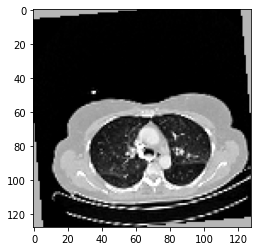

In [11]:
import matplotlib.pyplot as plt

img = x_train_aug[20]
print("Dimension of the CT scan is:", img.shape)
plt.imshow(img[:,:,80], cmap="gray")

### Define 3D convolutional neural network
The architecture of the CNN used in this example is based on this [paper](https://arxiv.org/abs/2007.13224)

In [60]:
def get_model(img_size, num_classes):
    # build a 3D convolutional neural network model

    inputs = keras.Input(img_size)

    x = layers.Conv3D(filters=16, kernel_size=3, activation='relu')(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)  

    x = layers.Conv3D(filters=32, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(units=256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation='sigmoid')(x)

    # define the model
    model = keras.Model(inputs, outputs)
    return model

# build model
model = get_model((128, 128, 128, 1), 2)
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 128, 1) 0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 126, 126, 126, 16) 448       
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 63, 63, 63, 16)    0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 63, 63, 63, 16)    64        
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 61, 61, 61, 32)    13856     
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 30, 30, 30, 32)    0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 30, 30, 32)   

### Train model



In [61]:
# compile model
# use the "binary_crossentropy"
# for the binary classification problem
model.compile(
    loss="binary_crossentropy", optimizer=keras.optimizers.Adam(1e-5), metrics=["acc"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint("3d_image_classification.h5", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_acc", patience=8),
]

# train the model, doing validation at the end of each epoch.
epochs = 100
model.fit(
    train_dataset,
    validation_data=test_dataset,
    batch_size=2,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=callbacks,
)

Epoch 1/100
14/14 - 2s - loss: 0.8080 - acc: 0.5000 - val_loss: 0.9940 - val_acc: 0.4167
Epoch 2/100
14/14 - 2s - loss: 0.3356 - acc: 0.8929 - val_loss: 0.9781 - val_acc: 0.5000
Epoch 3/100
14/14 - 2s - loss: 0.1788 - acc: 0.9643 - val_loss: 0.7878 - val_acc: 0.5000
Epoch 4/100
14/14 - 2s - loss: 0.1836 - acc: 0.9643 - val_loss: 0.7872 - val_acc: 0.5833
Epoch 5/100
14/14 - 2s - loss: 0.1509 - acc: 0.9286 - val_loss: 0.8286 - val_acc: 0.5000
Epoch 6/100
14/14 - 2s - loss: 0.1034 - acc: 1.0000 - val_loss: 0.8421 - val_acc: 0.5000
Epoch 7/100
14/14 - 2s - loss: 0.0557 - acc: 1.0000 - val_loss: 0.8598 - val_acc: 0.5000
Epoch 8/100
14/14 - 2s - loss: 0.0503 - acc: 1.0000 - val_loss: 0.8487 - val_acc: 0.5000
Epoch 9/100
14/14 - 2s - loss: 0.0536 - acc: 1.0000 - val_loss: 0.8733 - val_acc: 0.3333
Epoch 10/100
14/14 - 2s - loss: 0.0288 - acc: 1.0000 - val_loss: 0.9091 - val_acc: 0.3333
Epoch 11/100
14/14 - 2s - loss: 0.0228 - acc: 1.0000 - val_loss: 0.9440 - val_acc: 0.3333
Epoch 12/100
14/14 

It is important to note that the number of sample are really small (only 40) and no
random seed is specified. You can expect variances in your results. It is also a good
exersize to try other parameters and see what works!

## Visualizing model performance


Here the model accuracy and loss for the training and the validation sets are plotted. Since
the test set is class-balanced, accuracy provides an unbiased representation of the
errors.

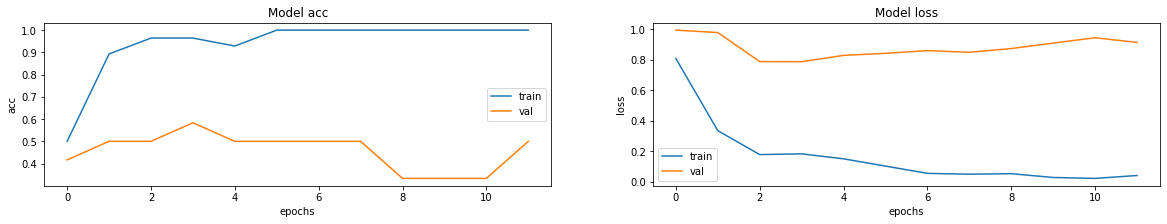

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[met])
    ax[i].plot(model.history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])


### Predict and evaluate results

In [63]:
# load best weights
model.load_weights("3d_image_classification.h5")
# evaluate model
score = model.evaluate(x_test, y_test, verbose=0)
# prin loss and accuracy on the test set
print("Test loss: %.2f" % (score[0]))
print("Test accuracy: %.2f" % (100 * score[1]))

Test loss: 0.79
Test accuracy: 58.33


Make predictions on a single CT scan

In [64]:
prediction = model.predict(np.expand_dims(x_test[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

CLASS_NAMES = ["left", "right"]
for score, name in zip(scores, CLASS_NAMES):
    print("This model is %.2f percent confident that cancer in the %s side" %((100 * score), name))

This model is 55.53 percent confident that cancer in the left side
This model is 44.47 percent confident that cancer in the right side
